<a href="https://colab.research.google.com/github/Heba-Atef99/FaceBoxes_Tensorflow/blob/main/Training/prepare_data/explore_and_prepare_MAFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import scipy.io
import os
from tqdm import tqdm
import pandas as pd
from PIL import Image, ImageDraw
import random
import cv2
import json
import tensorflow as tf
import io

# 1 Load MAFA Dataset

Mount the cotents of your drive into the files of colab to access the MAFA files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Copy MAFA folder from your drive to the content folder on google colab

In [ ]:
# cp -r directory_to_be_copied new_directory_of_the_copy
!cp -r /content/drive/MyDrive/FaceBoxes_Model/Datasets/MAFA /content

Separate training files from the testing files,, as when we unzip them both images become stored in the same folder

In [ ]:
TRAIN_DIR = '/content/MAFA/train/'
if not os.path.exists(TRAIN_DIR):
  os.mkdir(TRAIN_DIR)
  !mv /content/MAFA/MAFA-Label-Train.zip /content/MAFA/train/
  !mv /content/MAFA/train-images.zip /content/MAFA/train/

In [ ]:
TEST_DIR = '/content/MAFA/test/'
if not os.path.exists(TEST_DIR):
  os.mkdir(TEST_DIR)
  !mv /content/MAFA/MAFA-Label-Test.zip /content/MAFA/test/
  !mv /content/MAFA/test-images.zip /content/MAFA/test/

Unzip the MAFA files

In [ ]:
%cd /content/MAFA/train/
!unzip train-images.zip
!unzip MAFA-Label-Train.zip

%cd /content/MAFA/test/
!unzip test-images.zip
!unzip MAFA-Label-Test.zip

Check the count of the unziped folder contents

In [ ]:
%cd /content/MAFA/train/images
!ls -1 | wc -l

/content/MAFA/train/images
25876


In [ ]:
%cd /content/MAFA/test/images
!ls -1 | wc -l

/content/MAFA/test/images
4935


load labels in mat files, knowing that MAT-files are binary MATLAB® files that store workspace variables.

In [ ]:
matTrain = scipy.io.loadmat('/content/MAFA/train/LabelTrainAll.mat')
matTest = scipy.io.loadmat('/content/MAFA/test/LabelTestAll.mat')

Show the keys of the mat files

In [ ]:
print(matTrain.keys())
print(matTest.keys())

dict_keys(['__header__', '__version__', '__globals__', 'label_train'])
dict_keys(['__header__', '__version__', '__globals__', 'LabelTest'])


# 2 Prepare Train Set 

What is important for us to know for MAFA training set:

1) images folder puts the 25876 image files

2) the format is stored in a 18d array (x, y, w, h, x1, y1, x2, y2, x3, y3, w3, h3,  occ_type, occ_degree, gender, race, orientation, x4, y4, w4, h4), where:      

  (a) (x,y,w,h) is the bounding box of a face.

 

In [ ]:
#Read train
label_train = matTrain['label_train']
print(label_train.dtype)
print(label_train.shape,label_train.size)
print(label_train[0,0]['imgName'],label_train[0,0]['label'])

# store all images names from mat file in imgName variable 
imgName = label_train[0]['imgName']
label = label_train[0]['label']

[('orgImgName', 'O'), ('imgName', 'O'), ('label', 'O')]
(1, 25876) 25876
['train_00000001.jpg'] [[ 95 160  91  91 113 177 158 172   7  26  82  89   1   3   1   1   3  -1
   -1  -1  -1]]


explore the structure and accessting mechanism of labels & annotations 

In [ ]:
print(matTrain['label_train']['imgName'][0])
print(matTrain['label_train'][0][0]['label'][0][0:4])

[array(['train_00000001.jpg'], dtype='<U18')
 array(['train_00000002.jpg'], dtype='<U18')
 array(['train_00000003.jpg'], dtype='<U18') ...
 array(['train_00025874.jpg'], dtype='<U18')
 array(['train_00025875.jpg'], dtype='<U18')
 array(['train_00025876.jpg'], dtype='<U18')]
[ 95 160  91  91]


In [ ]:
print(imgName)

[array(['train_00000001.jpg'], dtype='<U18')
 array(['train_00000002.jpg'], dtype='<U18')
 array(['train_00000003.jpg'], dtype='<U18') ...
 array(['train_00025874.jpg'], dtype='<U18')
 array(['train_00025875.jpg'], dtype='<U18')
 array(['train_00025876.jpg'], dtype='<U18')]


## 2.1 Save the pathes of images

Our goal is to train the model on part of the MAFA dataset not all of it. So we will create a dataframe with only 1000 files to prepare and train the model with.

In [ ]:
IMAGES_DIR = '/content/MAFA/train/images/'
RESULT_DIR = '/content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/result/'

In [ ]:
metadata = pd.DataFrame()
trianBatch1 = imgName
metadata['image_name'] = trianBatch1
metadata['image_name'] = metadata.image_name.apply(lambda x: x[0])

# add root folder
metadata['full_path'] = metadata.image_name.apply(lambda x: os.path.join(x, IMAGES_DIR, x))

Have a look inside the metadata dataframe

In [ ]:
print(metadata.head())
print(metadata.tail())

           image_name                                      full_path
0  train_00000001.jpg  /content/MAFA/train/images/train_00000001.jpg
1  train_00000002.jpg  /content/MAFA/train/images/train_00000002.jpg
2  train_00000003.jpg  /content/MAFA/train/images/train_00000003.jpg
3  train_00000004.jpg  /content/MAFA/train/images/train_00000004.jpg
4  train_00000005.jpg  /content/MAFA/train/images/train_00000005.jpg
               image_name                                      full_path
25871  train_00025872.jpg  /content/MAFA/train/images/train_00025872.jpg
25872  train_00025873.jpg  /content/MAFA/train/images/train_00025873.jpg
25873  train_00025874.jpg  /content/MAFA/train/images/train_00025874.jpg
25874  train_00025875.jpg  /content/MAFA/train/images/train_00025875.jpg
25875  train_00025876.jpg  /content/MAFA/train/images/train_00025876.jpg


In [ ]:
# see all unique endings
metadata.image_name.apply(lambda x: x.split('.')[-1]).unique()

array(['jpg'], dtype=object)

explore an example with multiple faces

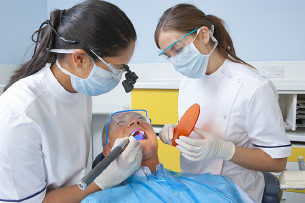

In [ ]:
Image.open(metadata['full_path'][250])

In [ ]:
print(metadata['full_path'][250])
print(imgName[250])
print(label[250])

/content/MAFA/train/images/train_00000251.jpg
['train_00000251.jpg']
[[ 68  37  62  62 115  70 124  72   2  29  56  63   1   3   2   2   5  -1
   -1  -1  -1]
 [163  37  43  43 169  57 178  50   7   9  44  43   1   3   2   1   1  -1
   -1  -1  -1]]


## 2.2 Save annotations of each image

In [ ]:
def slice_arr(x):
  y = []
  for b in x:
    b = b[0:4].astype(int)
    y.append(b)
  return y

metadata['annotations'] = label
metadata['annotations'] = metadata.annotations.apply(lambda x: slice_arr(x))

Have a look inside the metadata

In [ ]:
print(metadata.tail())

               image_name                                      full_path  \
25871  train_00025872.jpg  /content/MAFA/train/images/train_00025872.jpg   
25872  train_00025873.jpg  /content/MAFA/train/images/train_00025873.jpg   
25873  train_00025874.jpg  /content/MAFA/train/images/train_00025874.jpg   
25874  train_00025875.jpg  /content/MAFA/train/images/train_00025875.jpg   
25875  train_00025876.jpg  /content/MAFA/train/images/train_00025876.jpg   

               annotations  
25871  [[44, 4, 107, 107]]  
25872    [[31, 3, 80, 80]]  
25873   [[14, 28, 83, 83]]  
25874    [[38, 4, 72, 72]]  
25875   [[72, 16, 34, 34]]  


Make sure that the example we explored before is saved correctly

In [ ]:
print(metadata['full_path'][250])
print(metadata['image_name'][250])
print(metadata['annotations'][250])

/content/MAFA/train/images/train_00000251.jpg
train_00000251.jpg
[array([68, 37, 62, 62]), array([163,  37,  43,  43])]


Make sure that all images have JPEG format as some have other formats such as "PNG"

In [ ]:
def check_format(image_path):
  with tf.io.gfile.GFile(image_path, 'rb') as f:
      encoded_jpg = f.read()

  # check image format
  encoded_jpg_io = io.BytesIO(encoded_jpg)
  image = Image.open(encoded_jpg_io)
  if image.format != 'JPEG':
    return image.format
  return 'JPEG'

metadata['format'] = metadata.full_path
metadata['format'] = metadata.format.apply(lambda x: check_format(x))

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


show the different existing formats

In [ ]:
metadata.format.unique()

array(['JPEG', 'PNG', 'BMP', 'MPO'], dtype=object)

There are 285 image with a different format

In [ ]:
metadata.loc[metadata['format'] != 'JPEG']

image_name                                      full_path  \
6413   train_00006414.jpg  /content/MAFA/train/images/train_00006414.jpg   
6628   train_00006629.jpg  /content/MAFA/train/images/train_00006629.jpg   
10577  train_00010578.jpg  /content/MAFA/train/images/train_00010578.jpg   
10583  train_00010584.jpg  /content/MAFA/train/images/train_00010584.jpg   
10671  train_00010672.jpg  /content/MAFA/train/images/train_00010672.jpg   
...                   ...                                            ...   
23257  train_00023258.jpg  /content/MAFA/train/images/train_00023258.jpg   
23258  train_00023259.jpg  /content/MAFA/train/images/train_00023259.jpg   
23259  train_00023260.jpg  /content/MAFA/train/images/train_00023260.jpg   
23262  train_00023263.jpg  /content/MAFA/train/images/train_00023263.jpg   
23284  train_00023285.jpg  /content/MAFA/train/images/train_00023285.jpg   

                  annotations format  
6413    [[104, 51, 178, 178]]    PNG  
6628       [[34, 39, 52, 52]]    PNG  
10577     [[151, 59, 98, 98]]    PNG  
10583   [[163, 93, 148, 148]]    PNG  
10671     [[232, 64, 86, 86]]    PNG  
...                       ...    ...  
23257  [[115, 150, 233, 233]]    PNG  
23258    [[237, 122, 80, 80]]    PNG  
23259  [[234, 151, 243, 243]]    PNG  
23262  [[192, 186, 208, 208]]    PNG  
23284   [[351, 90, 108, 108]]    PNG  

[285 rows x 4 columns]

Remove all rows with different formats than JPEG

In [ ]:
metadata.drop(metadata[metadata['format'] != 'JPEG'].index, inplace = True)
print(metadata.format.unique())
print(len(metadata))
del metadata['format']
metadata.columns

['JPEG']
25591


Index(['image_name', 'full_path', 'annotations'], dtype='object')

## 2.3 Show some bounding boxes

In [ ]:
def draw_boxes_on_image(path, boxes):

    image = Image.open(path)
    draw = ImageDraw.Draw(image, 'RGBA')
    width, height = image.size

    for b in boxes:
        xmin, ymin, w, h = b
        xmax, ymax = xmin + w, ymin + h

        fill = (255, 255, 255, 45)
        outline = 'red'
        draw.rectangle(
            [(xmin, ymin), (xmax, ymax)],
            fill=fill, outline=outline
        )
    return image

train_00010645.jpg
[array([ 55,  67, 113, 113])]


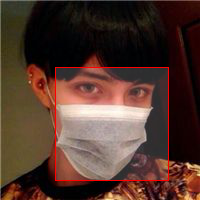

In [ ]:
i = random.randint(0, len(metadata) - 1)  # choose a random image
print(metadata.image_name[i])
some_boxes = metadata.annotations[i]
print(some_boxes)
draw_boxes_on_image(metadata.full_path[i], some_boxes)

## 2.4 Shuffle & Slice Dataframe

First shuffle the dataframe for randomness

In [ ]:
metadata = metadata.sample(frac = 1).reset_index(drop=True)


In [ ]:
print(metadata)

               image_name                                      full_path  \
0      train_00023727.jpg  /content/MAFA/train/images/train_00023727.jpg   
1      train_00014646.jpg  /content/MAFA/train/images/train_00014646.jpg   
2      train_00023931.jpg  /content/MAFA/train/images/train_00023931.jpg   
3      train_00001684.jpg  /content/MAFA/train/images/train_00001684.jpg   
4      train_00012564.jpg  /content/MAFA/train/images/train_00012564.jpg   
...                   ...                                            ...   
25586  train_00003206.jpg  /content/MAFA/train/images/train_00003206.jpg   
25587  train_00008440.jpg  /content/MAFA/train/images/train_00008440.jpg   
25588  train_00012890.jpg  /content/MAFA/train/images/train_00012890.jpg   
25589  train_00003746.jpg  /content/MAFA/train/images/train_00003746.jpg   
25590  train_00016794.jpg  /content/MAFA/train/images/train_00016794.jpg   

                  annotations  
0          [[52, 39, 83, 83]]  
1        [[423, 240, 66

Slice the metadata as we only need 1000 to fine tune our model in order not to result in more false positives 

In [ ]:
metadata = metadata[0:1000]
print(metadata)

             image_name                                      full_path  \
0    train_00023727.jpg  /content/MAFA/train/images/train_00023727.jpg   
1    train_00014646.jpg  /content/MAFA/train/images/train_00014646.jpg   
2    train_00023931.jpg  /content/MAFA/train/images/train_00023931.jpg   
3    train_00001684.jpg  /content/MAFA/train/images/train_00001684.jpg   
4    train_00012564.jpg  /content/MAFA/train/images/train_00012564.jpg   
..                  ...                                            ...   
995  train_00002720.jpg  /content/MAFA/train/images/train_00002720.jpg   
996  train_00000651.jpg  /content/MAFA/train/images/train_00000651.jpg   
997  train_00004928.jpg  /content/MAFA/train/images/train_00004928.jpg   
998  train_00024333.jpg  /content/MAFA/train/images/train_00024333.jpg   
999  train_00007067.jpg  /content/MAFA/train/images/train_00007067.jpg   

                annotations  
0        [[52, 39, 83, 83]]  
1      [[423, 240, 66, 66]]  
2      [[31, 30, 101,

## 2.5 Represent Data in JSON files

Create a new folder for the new converted dataset

In [ ]:
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

TRAIN_ANN_DIR = os.path.join(RESULT_DIR, 'train')
if not os.path.exists(TRAIN_ANN_DIR):
    os.mkdir(TRAIN_ANN_DIR)

ann_path = os.path.join(TRAIN_ANN_DIR, 'annotations')
if not os.path.exists(ann_path):
  os.mkdir(ann_path)

In [ ]:
def get_annotation(name, width, height):
    annotation = {
      "filename": name,
      "size": {"depth": 3, "width": width, "height": height}
    }
    objects = []
    boxes = metadata.annotations.loc[metadata["image_name"] == name]
    boxes = boxes.values[0]
    for b in boxes:
        xmin, ymin, w, h = b
        xmax, ymax = xmin + w, ymin + h
        objects.append({
            "bndbox": {"ymin": int(ymin), "ymax": int(ymax), "xmax": int(xmax), "xmin": int(xmin)}, 
            "name": "face"
        })
    annotation["object"] = objects
    return annotation

In [ ]:
for T in tqdm(metadata.itertuples()):
    # get width and height of an image
    image = cv2.imread(T.full_path)
    h, w, c = image.shape
    assert c == 3
    
    # name of the image
    name = T.image_name
    assert name.endswith('.jpg')
    
    # save annotation for it
    d = get_annotation(name, w, h)
    json_name = name[:-4] + '.json'
    json.dump(d, open(os.path.join(TRAIN_ANN_DIR, 'annotations', json_name), 'w')) 

1000it [00:15, 63.63it/s]


have a look inside the annotations folder

In [ ]:
%cd /content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/result/train/annotations/
!ls -1 | wc -l
!ls

/content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/result/train/annotations
1000
train_00000003.json  train_00009002.json  train_00017436.json
train_00000008.json  train_00009052.json  train_00017440.json
train_00000023.json  train_00009066.json  train_00017461.json
train_00000039.json  train_00009080.json  train_00017535.json
train_00000043.json  train_00009108.json  train_00017576.json
train_00000065.json  train_00009126.json  train_00017616.json
train_00000081.json  train_00009135.json  train_00017622.json
train_00000093.json  train_00009148.json  train_00017658.json
train_00000113.json  train_00009151.json  train_00017691.json
train_00000166.json  train_00009154.json  train_00017700.json
train_00000177.json  train_00009160.json  train_00017710.json
train_00000181.json  train_00009177.json  train_00017711.json
train_00000228.json  train_00009225.json  train_00017713.json
train_00000230.json  train_00009278.json  train_00017733.json
train_00000251.json  train_00009290.json  tr

look inside one of the annotations JSON files

In [ ]:
a_file = open(TRAIN_ANN_DIR+"/annotations/train_00001432.json", "r")
a_json = json.load(a_file)
pretty_json = json.dumps(a_json, indent=4)
a_file.close()

print(pretty_json)

{
    "filename": "train_00001432.jpg",
    "size": {
        "depth": 3,
        "width": 1500,
        "height": 930
    },
    "object": [
        {
            "bndbox": {
                "ymin": 240,
                "ymax": 763,
                "xmax": 864,
                "xmin": 341
            },
            "name": "face"
        }
    ]
}


## 2.5 Create TF Records

In [ ]:
!python3 "/content/drive/MyDrive/FaceBoxes_Model/Training_Code/create_tfrecords.py" --image_dir=/content/MAFA/train/images/ --annotations_dir=/content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/result/train/annotations/ --output=/content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/train_shards/ --num_shards=150

Reading images from: /content/MAFA/train/images/
Reading annotations from: /content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/result/train/annotations/ 

Number of images: 1000
Number of images per shard: 7
100% 1000/1000 [00:06<00:00, 161.81it/s]
Result is here: /content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/train_shards/


have a look inside the train_shards folder

In [ ]:
%cd /content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/train_shards/
!ls

/content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/train_shards
shard-0000.tfrecords  shard-0048.tfrecords  shard-0096.tfrecords
shard-0001.tfrecords  shard-0049.tfrecords  shard-0097.tfrecords
shard-0002.tfrecords  shard-0050.tfrecords  shard-0098.tfrecords
shard-0003.tfrecords  shard-0051.tfrecords  shard-0099.tfrecords
shard-0004.tfrecords  shard-0052.tfrecords  shard-0100.tfrecords
shard-0005.tfrecords  shard-0053.tfrecords  shard-0101.tfrecords
shard-0006.tfrecords  shard-0054.tfrecords  shard-0102.tfrecords
shard-0007.tfrecords  shard-0055.tfrecords  shard-0103.tfrecords
shard-0008.tfrecords  shard-0056.tfrecords  shard-0104.tfrecords
shard-0009.tfrecords  shard-0057.tfrecords  shard-0105.tfrecords
shard-0010.tfrecords  shard-0058.tfrecords  shard-0106.tfrecords
shard-0011.tfrecords  shard-0059.tfrecords  shard-0107.tfrecords
shard-0012.tfrecords  shard-0060.tfrecords  shard-0108.tfrecords
shard-0013.tfrecords  shard-0061.tfrecords  shard-0109.tfrecords
shard-0014.tfrecord

look inside the tfrecord

In [ ]:
for example in tf.compat.v1.io.tf_record_iterator("/content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/train_shards/shard-0095.tfrecords"):
    print(tf.train.Example.FromString(example))

features {
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "train_00019026.jpg"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\000`\000`\000\000\377\341\000\"Exif\000\000MM\000*\000\000\000\010\000\001\001\022\000\003\000\000\000\001\000\001\000\000\000\000\000\000\377\354\000\021Ducky\000\001\000\004\000\000\000P\000\000\377\333\000C\000\002\001\001\002\001\001\002\002\002\002\002\002\002\002\003\005\003\003\003\003\003\006\004\004\003\005\007\006\007\007\007\006\007\007\010\t\013\t\010\010\n\010\007\007\n\r\n\n\013\014\014\014\014\007\t\016\017\r\014\016\013\014\014\014\377\333\000C\001\002\002\002\003\003\003\006\003\003\006\014\010\007\010\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\014\377\300\000\021\010\0019\0

# 3 Prepare Test Set

What is important for us to know for MAFA test set:

1) images folder puts the 4935 image files

2) the format is stored in a 18d array (x, y, w, h, face_type, x1, y1, w1, h1, occ_type, occ_degree, gender, race, orientation, x2, y2, w2, h2), where:      

  (a) (x,y,w,h) is the bounding box of a face.

 

In [ ]:
#Read test
label_test = matTest['LabelTest']
print(label_test.dtype)
print(label_test.shape,label_test.size)
print(label_test[0,0]['name'],label_test[0,0]['label'])

# store all images names from mat file in imgName variable 
testImgName = label_test[0]['name']
testLabel = label_test[0]['label']

[('name', 'O'), ('label', 'O')]
(1, 4935) 4935
['test_00000001.jpg'] [[2694 1211  353  353    1    9  105  144  337    2    3    2    2    1
    -1   -1   -1   -1]
 [1754 1449   68   68    3   -1   -1   -1   -1   -1   -1   -1   -1   -1
    -1   -1   -1   -1]]


explore the structure and accessting mechanism of labels & annotations 

In [ ]:
print(testImgName)
print(testLabel)

[array(['test_00000001.jpg'], dtype='<U17')
 array(['test_00000002.jpg'], dtype='<U17')
 array(['test_00000003.jpg'], dtype='<U17') ...
 array(['test_00004933.jpg'], dtype='<U17')
 array(['test_00004934.jpg'], dtype='<U17')
 array(['test_00004935.jpg'], dtype='<U17')]
[array([[2694, 1211,  353,  353,    1,    9,  105,  144,  337,    2,    3,
            2,    2,    1,   -1,   -1,   -1,   -1],
        [1754, 1449,   68,   68,    3,   -1,   -1,   -1,   -1,   -1,   -1,
           -1,   -1,   -1,   -1,   -1,   -1,   -1]], dtype=int16)
 array([[113,  95, 226, 226,   1,   9,  71, 181, 221,   1,   3,   1,   2,
           3,  -1,  -1,  -1,  -1]], dtype=int16)
 array([[352, 114, 151, 151,   1,  17,  45, 137, 135,   1,   3,   2,   2,
           3,  -1,  -1,  -1,  -1],
        [799, 217, 139, 139,   2,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1]], dtype=int16)
 ...
 array([[ 80, 121, 245, 245,   1,  50,  81, 238, 242,   1,   3,   2,   2,
           3,  -1,  -1,  -1, 

## 3.1 Save the pathes of images

Our goal is to train the model on part of the MAFA dataset not all of it. So we will create a dataframe with only 429 files to prepare and validate the model with.

So we have 70:30 train:validate ratio

In [ ]:
TEST_IMAGES_DIR = '/content/MAFA/test/images/'

In [ ]:
metadata2 = pd.DataFrame()

testBatch1 = testImgName
metadata2['image_name'] = testBatch1
metadata2['image_name'] = metadata2.image_name.apply(lambda x: x[0])

# add root folder
metadata2['full_path'] = metadata2.image_name.apply(lambda x: os.path.join(x, TEST_IMAGES_DIR, x))

Have a look inside the metadata dataframe

In [ ]:
print(metadata2.head())
print(metadata2.tail())

          image_name                                    full_path
0  test_00000001.jpg  /content/MAFA/test/images/test_00000001.jpg
1  test_00000002.jpg  /content/MAFA/test/images/test_00000002.jpg
2  test_00000003.jpg  /content/MAFA/test/images/test_00000003.jpg
3  test_00000004.jpg  /content/MAFA/test/images/test_00000004.jpg
4  test_00000005.jpg  /content/MAFA/test/images/test_00000005.jpg
             image_name                                    full_path
4930  test_00004931.jpg  /content/MAFA/test/images/test_00004931.jpg
4931  test_00004932.jpg  /content/MAFA/test/images/test_00004932.jpg
4932  test_00004933.jpg  /content/MAFA/test/images/test_00004933.jpg
4933  test_00004934.jpg  /content/MAFA/test/images/test_00004934.jpg
4934  test_00004935.jpg  /content/MAFA/test/images/test_00004935.jpg


In [ ]:
# see all unique endings
metadata2.image_name.apply(lambda x: x.split('.')[-1]).unique()

array(['jpg'], dtype=object)

explore an example with multiple faces

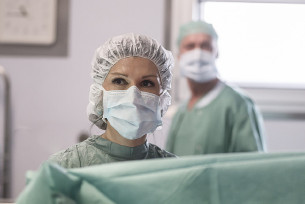

In [ ]:
Image.open(metadata2['full_path'][250])

In [ ]:
print(metadata2['full_path'][250])
print(testImgName[250])
print(testLabel[250])

/content/MAFA/test/images/test_00000251.jpg
['test_00000251.jpg']
[[100  68  70  70   1   4  24  62  68   1   3   2   1   3  -1  -1  -1  -1]
 [176  39  42  42   3  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]]


## 3.2 Save annotations of each image

In [ ]:
def slice_arr(x):
  y = []
  for b in x:
    b = b[0:4].astype(int)
    y.append(b)
  return y

metadata2['annotations'] = testLabel
metadata2['annotations'] = metadata2.annotations.apply(lambda x: slice_arr(x))

Have a look inside the metadata

In [ ]:
print(metadata2.head())

          image_name                                    full_path  \
0  test_00000001.jpg  /content/MAFA/test/images/test_00000001.jpg   
1  test_00000002.jpg  /content/MAFA/test/images/test_00000002.jpg   
2  test_00000003.jpg  /content/MAFA/test/images/test_00000003.jpg   
3  test_00000004.jpg  /content/MAFA/test/images/test_00000004.jpg   
4  test_00000005.jpg  /content/MAFA/test/images/test_00000005.jpg   

                                      annotations  
0  [[2694, 1211, 353, 353], [1754, 1449, 68, 68]]  
1                           [[113, 95, 226, 226]]  
2    [[352, 114, 151, 151], [799, 217, 139, 139]]  
3                          [[162, 126, 124, 124]]  
4       [[197, 109, 123, 123], [18, 208, 76, 76]]  


Make sure that the example we explored before is saved correctly

In [ ]:
print(metadata2['full_path'][250])
print(metadata2['image_name'][250])
print(metadata2['annotations'][250])

/content/MAFA/test/images/test_00000251.jpg
test_00000251.jpg
[array([100,  68,  70,  70]), array([176,  39,  42,  42])]


Make sure that all images have JPEG format as some have other formats such as "PNG"

In [ ]:
def check_format(image_path):
  with tf.io.gfile.GFile(image_path, 'rb') as f:
      encoded_jpg = f.read()

  # check image format
  encoded_jpg_io = io.BytesIO(encoded_jpg)
  image = Image.open(encoded_jpg_io)
  if image.format != 'JPEG':
    return image.format
  return 'JPEG'

metadata2['format'] = metadata2.full_path
metadata2['format'] = metadata2.format.apply(lambda x: check_format(x))

show the different existing formats

In [ ]:
metadata2.format.unique()

array(['JPEG', 'PNG', 'BMP'], dtype=object)

There are 95 image with a different format

In [ ]:
metadata2.loc[metadata2['format'] != 'JPEG']

image_name                                    full_path  \
28    test_00000029.jpg  /content/MAFA/test/images/test_00000029.jpg   
643   test_00000644.jpg  /content/MAFA/test/images/test_00000644.jpg   
979   test_00000980.jpg  /content/MAFA/test/images/test_00000980.jpg   
1028  test_00001029.jpg  /content/MAFA/test/images/test_00001029.jpg   
1116  test_00001117.jpg  /content/MAFA/test/images/test_00001117.jpg   
...                 ...                                          ...   
4690  test_00004691.jpg  /content/MAFA/test/images/test_00004691.jpg   
4691  test_00004692.jpg  /content/MAFA/test/images/test_00004692.jpg   
4697  test_00004698.jpg  /content/MAFA/test/images/test_00004698.jpg   
4727  test_00004728.jpg  /content/MAFA/test/images/test_00004728.jpg   
4732  test_00004733.jpg  /content/MAFA/test/images/test_00004733.jpg   

                                            annotations format  
28                               [[297, 255, 134, 134]]    PNG  
643            [[215, 133, 47, 47], [341, 124, 43, 43]]    PNG  
979   [[42, 109, 107, 107], [232, 110, 107, 107], [4...    BMP  
1028                                 [[53, 32, 93, 93]]    PNG  
1116  [[28, 65, 65, 65], [81, 81, 51, 51], [133, 90,...    PNG  
...                                                 ...    ...  
4690                                [[102, 58, 77, 77]]    PNG  
4691                              [[104, 34, 238, 238]]    PNG  
4697  [[315, 71, 83, 83], [209, 172, 12, 12], [153, ...    PNG  
4727                                [[125, 43, 91, 91]]    PNG  
4732                                 [[55, 58, 89, 89]]    PNG  

[95 rows x 4 columns]

Remove all rows with different formats than JPEG

In [ ]:
metadata2.drop(metadata2[metadata2['format'] != 'JPEG'].index, inplace = True)
print(metadata2.format.unique())
print(len(metadata2))
del metadata2['format']
metadata2.columns

['JPEG']
4840


Index(['image_name', 'full_path', 'annotations'], dtype='object')

## 3.3 Show some bounding boxes

In [ ]:
def draw_boxes_on_image(path, boxes):

    image = Image.open(path)
    draw = ImageDraw.Draw(image, 'RGBA')
    width, height = image.size

    for b in boxes:
        xmin, ymin, w, h = b
        xmax, ymax = xmin + w, ymin + h

        fill = (255, 255, 255, 45)
        outline = 'red'
        draw.rectangle(
            [(xmin, ymin), (xmax, ymax)],
            fill=fill, outline=outline
        )
    return image

test_00000807.jpg
[array([252, 437, 243, 243])]


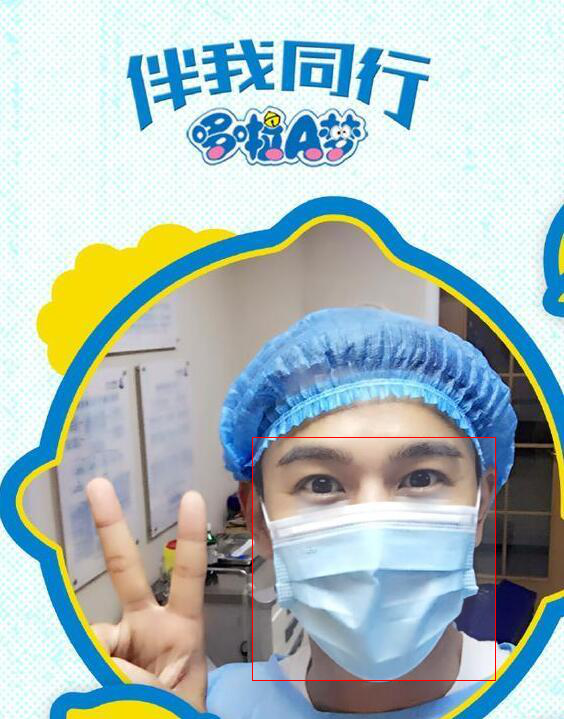

In [ ]:
i = random.randint(0, len(metadata2) - 1)  # choose a random image
print(metadata2.image_name[i])
some_boxes = metadata2.annotations[i]
print(some_boxes)
draw_boxes_on_image(metadata2.full_path[i], some_boxes)

## 3.4 Shuffle & Slice Dataframe

First shuffle the dataframe for randomness

In [ ]:
metadata2 = metadata2.sample(frac = 1).reset_index(drop=True)


In [ ]:
print(metadata2)

             image_name                                    full_path  \
0     test_00000558.jpg  /content/MAFA/test/images/test_00000558.jpg   
1     test_00001441.jpg  /content/MAFA/test/images/test_00001441.jpg   
2     test_00003652.jpg  /content/MAFA/test/images/test_00003652.jpg   
3     test_00003519.jpg  /content/MAFA/test/images/test_00003519.jpg   
4     test_00001831.jpg  /content/MAFA/test/images/test_00001831.jpg   
...                 ...                                          ...   
4835  test_00000201.jpg  /content/MAFA/test/images/test_00000201.jpg   
4836  test_00003629.jpg  /content/MAFA/test/images/test_00003629.jpg   
4837  test_00002859.jpg  /content/MAFA/test/images/test_00002859.jpg   
4838  test_00001570.jpg  /content/MAFA/test/images/test_00001570.jpg   
4839  test_00001271.jpg  /content/MAFA/test/images/test_00001271.jpg   

                                            annotations  
0                                [[395, 487, 497, 497]]  
1                  

Slice the metadata as we only need 429 to fine tune our model with 70:30 ratio

In [ ]:
metadata2 = metadata2[0:429]
print(metadata2)

            image_name                                    full_path  \
0    test_00000558.jpg  /content/MAFA/test/images/test_00000558.jpg   
1    test_00001441.jpg  /content/MAFA/test/images/test_00001441.jpg   
2    test_00003652.jpg  /content/MAFA/test/images/test_00003652.jpg   
3    test_00003519.jpg  /content/MAFA/test/images/test_00003519.jpg   
4    test_00001831.jpg  /content/MAFA/test/images/test_00001831.jpg   
..                 ...                                          ...   
424  test_00004888.jpg  /content/MAFA/test/images/test_00004888.jpg   
425  test_00000830.jpg  /content/MAFA/test/images/test_00000830.jpg   
426  test_00000755.jpg  /content/MAFA/test/images/test_00000755.jpg   
427  test_00000976.jpg  /content/MAFA/test/images/test_00000976.jpg   
428  test_00000564.jpg  /content/MAFA/test/images/test_00000564.jpg   

                                           annotations  
0                               [[395, 487, 497, 497]]  
1                               [

## 3.5 Represent Data in JSON files

Create a new folder for the new converted dataset

In [ ]:
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)

TEST_ANN_DIR = os.path.join(RESULT_DIR, 'test')
if not os.path.exists(TEST_ANN_DIR):
    os.mkdir(TEST_ANN_DIR)

ann_path = os.path.join(TEST_ANN_DIR, 'annotations')
if not os.path.exists(ann_path):
  os.mkdir(ann_path)

In [ ]:
def get_annotation(name, width, height):
    annotation = {
      "filename": name,
      "size": {"depth": 3, "width": width, "height": height}
    }
    objects = []
    boxes = metadata2.annotations.loc[metadata2["image_name"] == name]
    boxes = boxes.values[0]
    for b in boxes:
        xmin, ymin, w, h = b
        xmax, ymax = xmin + w, ymin + h
        objects.append({
            "bndbox": {"ymin": int(ymin), "ymax": int(ymax), "xmax": int(xmax), "xmin": int(xmin)}, 
            "name": "face"
        })
    annotation["object"] = objects
    return annotation

In [ ]:
for T in tqdm(metadata2.itertuples()):
    # get width and height of an image
    image = cv2.imread(T.full_path)
    h, w, c = image.shape
    assert c == 3
    
    # name of the image
    name = T.image_name
    assert name.endswith('.jpg')
    
    # save annotation for it
    d = get_annotation(name, w, h)
    json_name = name[:-4] + '.json'
    json.dump(d, open(os.path.join(TEST_ANN_DIR, 'annotations', json_name), 'w')) 

429it [00:07, 57.23it/s]


have a look inside the annotations folder

In [ ]:
%cd /content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/result/test/annotations/
!ls -1 | wc -l
!ls

/content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/result/test/annotations
429
test_00000033.json  test_00001183.json	test_00002304.json  test_00003694.json
test_00000045.json  test_00001203.json	test_00002318.json  test_00003722.json
test_00000086.json  test_00001205.json	test_00002319.json  test_00003723.json
test_00000093.json  test_00001211.json	test_00002380.json  test_00003749.json
test_00000103.json  test_00001217.json	test_00002388.json  test_00003750.json
test_00000105.json  test_00001232.json	test_00002394.json  test_00003757.json
test_00000107.json  test_00001242.json	test_00002395.json  test_00003774.json
test_00000108.json  test_00001244.json	test_00002398.json  test_00003805.json
test_00000140.json  test_00001257.json	test_00002442.json  test_00003809.json
test_00000141.json  test_00001262.json	test_00002443.json  test_00003815.json
test_00000147.json  test_00001267.json	test_00002454.json  test_00003829.json
test_00000155.json  test_00001276.json	test_00002462.jso

look inside one of the annotations JSON files

In [ ]:
a_file = open(TEST_ANN_DIR+"/annotations/test_00002961.json", "r")
a_json = json.load(a_file)
pretty_json = json.dumps(a_json, indent=4)
a_file.close()

print(pretty_json)

{
    "filename": "test_00002961.jpg",
    "size": {
        "depth": 3,
        "width": 800,
        "height": 702
    },
    "object": [
        {
            "bndbox": {
                "ymin": 384,
                "ymax": 635,
                "xmax": 328,
                "xmin": 77
            },
            "name": "face"
        },
        {
            "bndbox": {
                "ymin": 325,
                "ymax": 601,
                "xmax": 662,
                "xmin": 386
            },
            "name": "face"
        }
    ]
}


## 3.6 Create TF Records

In [ ]:
!python3 "/content/drive/MyDrive/FaceBoxes_Model/Training_Code/create_tfrecords.py" --image_dir=/content/MAFA/test/images/ --annotations_dir=/content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/result/test/annotations/ --output=/content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/val_shards/ --num_shards=20

Reading images from: /content/MAFA/test/images/
Reading annotations from: /content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/result/test/annotations/ 

Number of images: 429
Number of images per shard: 22
100% 429/429 [00:01<00:00, 258.82it/s]
Result is here: /content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/val_shards/


have a look inside the train_shards folder

In [ ]:
%cd /content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/val_shards/
!ls

/content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/val_shards
shard-0000.tfrecords  shard-0007.tfrecords  shard-0014.tfrecords
shard-0001.tfrecords  shard-0008.tfrecords  shard-0015.tfrecords
shard-0002.tfrecords  shard-0009.tfrecords  shard-0016.tfrecords
shard-0003.tfrecords  shard-0010.tfrecords  shard-0017.tfrecords
shard-0004.tfrecords  shard-0011.tfrecords  shard-0018.tfrecords
shard-0005.tfrecords  shard-0012.tfrecords  shard-0019.tfrecords
shard-0006.tfrecords  shard-0013.tfrecords


look inside the tfrecord

In [ ]:
for example in tf.compat.v1.io.tf_record_iterator("/content/drive/MyDrive/FaceBoxes_Model/Training_Code/mafa/train_shards/shard-0009.tfrecords"):
    print(tf.train.Example.FromString(example))

features {
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "train_00017884.jpg"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\000H\000H\000\000\377\333\000C\000\004\002\003\003\003\002\004\003\003\003\004\004\004\004\005\t\006\005\005\005\005\013\010\010\006\t\r\013\r\r\r\013\014\014\016\020\024\021\016\017\023\017\014\014\022\030\022\023\025\026\027\027\027\016\021\031\033\031\026\032\024\026\027\026\377\333\000C\001\004\004\004\005\005\005\n\006\006\n\026\017\014\017\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\026\377\300\000\021\010\002s\001\360\003\001\"\000\002\021\001\003\021\001\377\304\000\035\000\000\000\007\001\001\001\000\000\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\000\010\t\377\304\00